<a href="https://colab.research.google.com/github/Bprs68/Rossmann-Sales-Prediction-/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [3]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

import warnings    
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# setting folder path for location where store data is kept
file_path_stores_data= '/content/drive/MyDrive/AlmaBetter/Team Capstone Projects/Capstone Project - Supervised Machine Learning- Regression/Data/Copy of store.csv'
file_path_rossman_stores_data = '/content/drive/MyDrive/AlmaBetter/Team Capstone Projects/Capstone Project - Supervised Machine Learning- Regression/Data/Copy of Rossmann Stores Data.csv'

In [6]:
#reading csv from rossman stores data file path
df = pd.read_csv(file_path_rossman_stores_data)

#reading csv from stores data file path
stores_df = pd.read_csv(file_path_stores_data)

In [7]:
#getting first few rows of data
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
#checking shape of data
df.shape

(1017209, 9)

In [9]:
#checking null values
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

*so there are no null values in the data, let's go ahead and check stores data.*

In [10]:
# getting first few rows of stores data
stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
# getting info for stores dataframe
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
# number of null values in stores dataframe
stores_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
# checking description of dataframe
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


##### Since competition distance only has three null values, but has a standard deviation of around 7663 points, it might be heavily influenced by outliers. Checking that with the help of a boxplot.



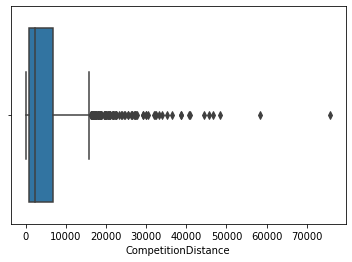

In [14]:
# boxplot for competition distance
sns.boxplot(stores_df['CompetitionDistance'])

There are some outlier values in CompetitionDistance column, so we will replace null values with median values.

In [15]:
# creating a function to impute median
def impute_median(series):
  return series.fillna(series.median())

In [16]:
# applying impute median function to conver null values in stores data with median
stores_df['CompetitionDistance'] = stores_df['CompetitionDistance'].transform(impute_median)

In [17]:
stores_df['CompetitionDistance'].isnull().sum()

0

Replacing null values in "CompetitionOpenSinceMonth" and "CompetitionOpenSinceYear" with most frequent values, since competition distance for these rows are given.

In [18]:
stores_df['CompetitionOpenSinceMonth'].fillna(stores_df['CompetitionOpenSinceMonth'].mode()[0], inplace=True)
stores_df['CompetitionOpenSinceYear'].fillna(stores_df['CompetitionOpenSinceYear'].mode()[0], inplace=True)

Now, replacing null values in columns "Promo2SinceWeek", "Promo2SinceYear", and "PromoIntervals" with 0.

In [19]:
stores_df['Promo2SinceWeek'].fillna(0, inplace=True)
stores_df['Promo2SinceYear'].fillna(0, inplace=True)
stores_df['PromoInterval'].fillna(0, inplace=True)

Checking null values in stores dataframe again.

In [20]:
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Merging both the dataframes

In [21]:
df = df.merge(right = stores_df, how='left', on='Store')

In [22]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [23]:
#printing all the columns in our merged dataset 
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

###**Looking at columns, some assumptions can be made intuitively before diving into data to know whether they are valid or not.**

*   For "DayOfTheWeek" column maximum average sales must be happening on Day 1, i.e. Monday, since this is the day after weekend. 

*   Sales and Customers must be correlated.

*   As obvious, Sales would be zero on days when stores were not open.

*   Promo should contribute to more average sales for days it was running.

*   Stores can be expected to have less sales on stateholidays as most of them were closed, but for those open, sales might be higher.

*   On SchoolHolidays, stores are mostly open, that might contribute to more sales on these days.

*   We will need to find relationship between store type and average sales per store type and same goes for assortment.

*   But we can assume that stores with more assortment type to have higher average sales.

*   Stores with more competition distance might have more sales.

*   CompetitionOpenSinceMonth and CompetitionOpenSinceYear, both might be highly collinear to each other.

*   Promo2 should contribute to more sales, and 'Promo2SinceWeek',
  'Promo2SinceYear' should be collinear to each other.

*   Days falling in PromoInterval must have more sales.







In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [25]:
# replacing string 0 in state holidays with integer zero
df['StateHoliday'].replace({'0':0}, inplace=True)

In [26]:
# in date column, values are in string format, converting it into DateTime.
df['Date'] = pd.to_datetime(df['Date'])

In [27]:
#creating different columns for each element of datetime
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.weekofyear
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Year'].unique()

array([2015, 2014, 2013])

Creating barplot for each column against sales to see how each column is behaving with respect to different values in them.

In [28]:
# creating a list of categorical columns 
cat_columns = ['DayOfWeek', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2', 'PromoInterval']

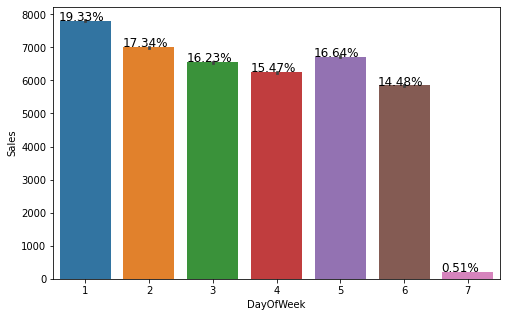

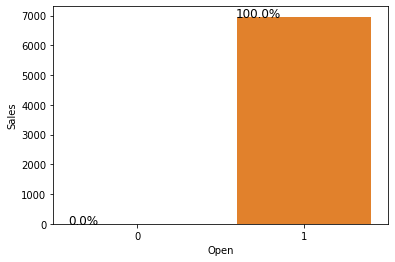

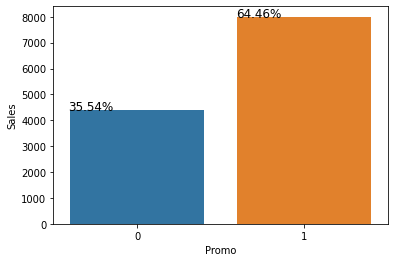

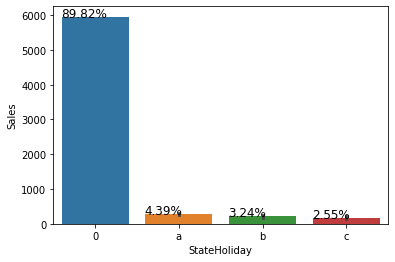

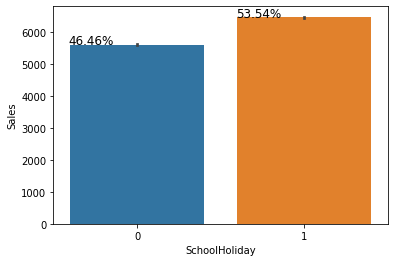

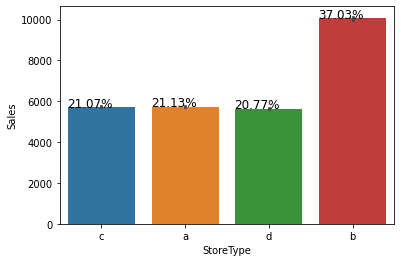

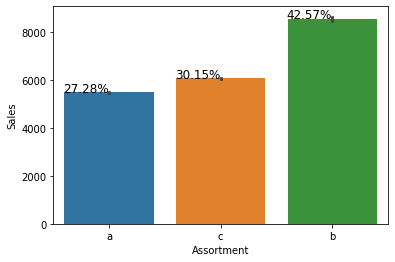

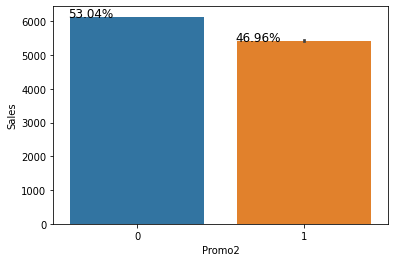

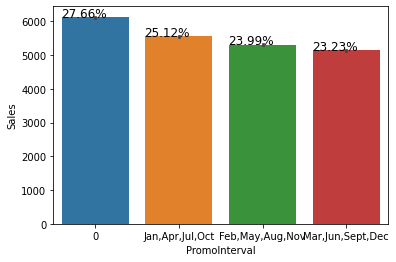

In [29]:
plt.figure(figsize=(8,5))
for value in cat_columns:
  ax = sns.barplot(data = df, x=value, y='Sales')
  plt.xlabel(value)
  plt.ylabel('Sales')
  totals = []
  for i in ax.patches: #for every patch in the barplot ax
      totals.append(i.get_height()) #append height for each patch

  total = sum(totals) #sum of each patch height for a plot

  for i in ax.patches:  
      ax.text(i.get_x() - .01, i.get_height() + .5, \
              str(round((i.get_height()/total)*100, 2))+'%', fontsize=12)  #text position and formula for percentage
  plt.show()

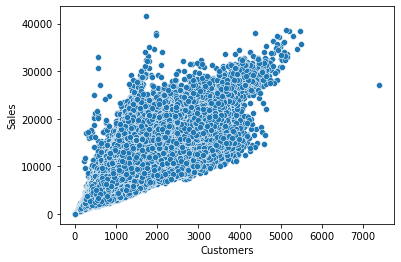

In [30]:
# creating a scatterplot to check correlation between customer and sales
sns.scatterplot(data=df, x='Customers', y='Sales')

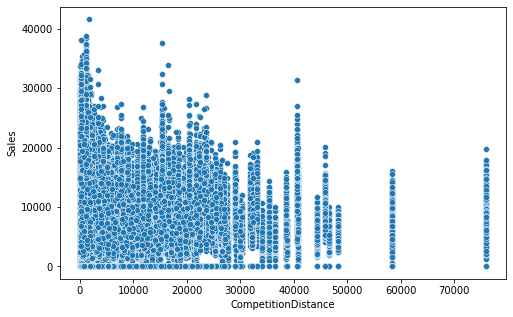

In [31]:
# a scatterplot to check whether or not CompetitionDistance and Sales are correlated
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='CompetitionDistance', y='Sales')

### **Insights from above plots:**

*   It varifies our assumption that Mondays are days with most sales, and Sundays are ones with least.

*   Stores with assortment level b offers contributes highest average sales.

*   Stores peform a lot well when Promo is running.

*   Seems like less stores are open on State Holidays, hence less average sales are recorded.

*   On school holidays, sales are comparatively higher.

*   Store type b has highest average sales.

*   Average sales are low when Promo2 is running, we will try finding reasons for that, one assumption is stores were participating less.

*  As assumed customer and sales has positive correlation, except for some rare outliers.

*  Opposite to intuition, Sales and Competition distance are actually negatively correlated, and stores having less competition distance actually has more sales.

In [32]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear'],
      dtype='object')

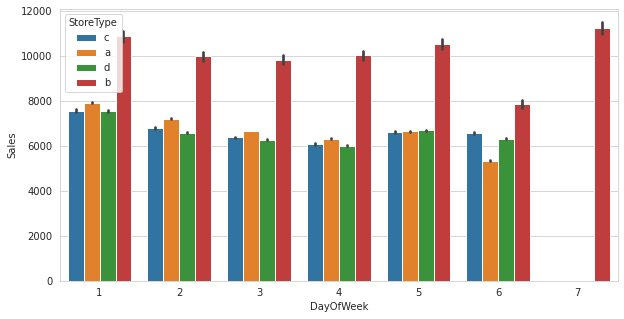

In [33]:
#barplot for average sales for each day of week for each store type
sns.set_style("whitegrid") 
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='DayOfWeek', y='Sales', hue='StoreType')

It can be observed that except store type b, almost all other store type were mostly closed on Sundays

Exploring relationship between StoreType and Assortment with reference to Sales

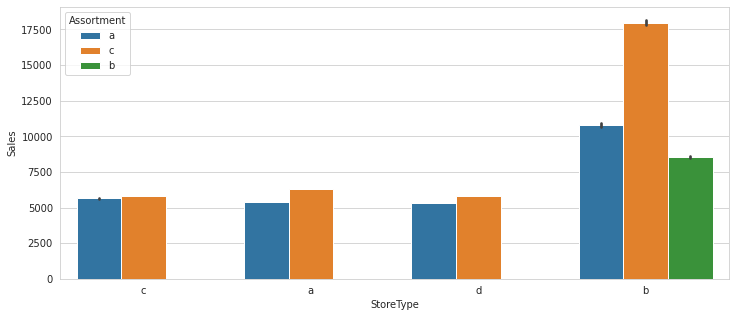

In [34]:
plt.figure(figsize=(12,5))
sns.barplot(data=df, x='StoreType', y='Sales', hue='Assortment')

This explains why storetype b had the best average sales of all other store types, it has three assortments available, and also this was the only storetype open even on sundays.

Now, let's see customer distribution over Storetypes.

In [35]:
df.groupby('StoreType')['Customers'].sum().sort_values(ascending=False).reset_index()

,StoreType,Customers
0,a,363541434
1,d,156904995
2,c,92129705
3,b,31465621


Sales and customer distribution over store types.

In [36]:
mg = df.groupby('StoreType')['Customers','Sales'].sum().sort_values(by=['Customers','Sales'],ascending=False).reset_index()
mg

,StoreType,Customers,Sales
0,a,363541434,3165334859
1,d,156904995,1765392943
2,c,92129705,783221426
3,b,31465621,159231395


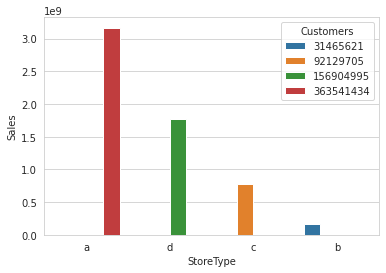

In [37]:
sns.barplot(data=mg, x='StoreType',y='Sales', hue='Customers')

Seems like Store a has maximum number of customers and most revenue overall as well.

In [38]:
dist_store = df.groupby('StoreType')['Customers','Sales'].sum().sort_values(by=['Customers','Sales'],ascending=False).reset_index()

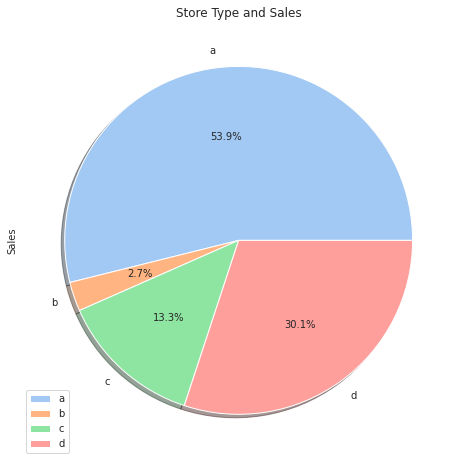

In [39]:
plt.figure(figsize=(8, 8))
df.groupby("StoreType")["Sales"].sum().plot.pie(title='Store Type and Sales', legend=True, autopct='%1.1f%%', shadow=True, colors=sns.color_palette('pastel')[0:5])

Storetype a accounts for around 54 percent of all Sales happening in data. Let's try visualising number of customers in each store type.

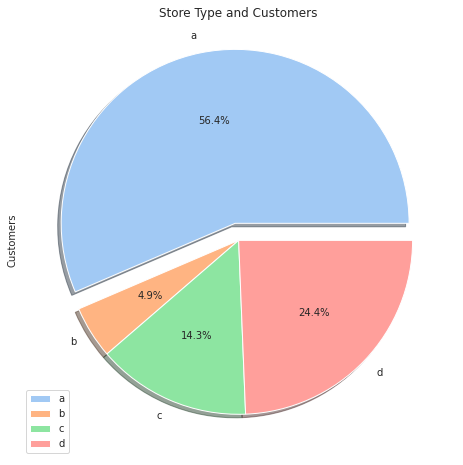

In [40]:
plt.figure(figsize=(8, 8))
explode = [0.1,0,0,0]
df.groupby("StoreType")["Customers"].sum().plot.pie(title='Store Type and Customers', legend=True, autopct='%1.1f%%', shadow=True, colors=sns.color_palette('pastel')[0:5], explode=explode)

Here also, StoreType a has highest share of customers, i.e, around 56 percent, after that comes store type d, then c and b respectively

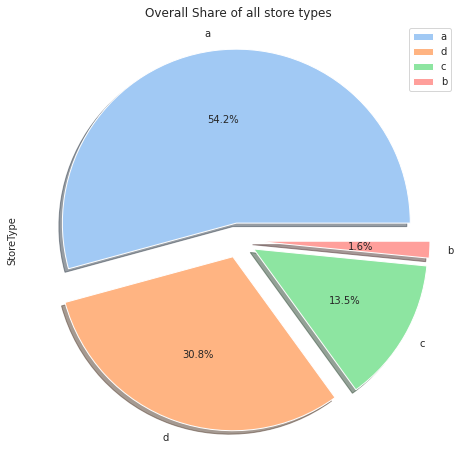

In [41]:
# overall share of stores in entire data
plt.figure(figsize=(8, 8))
df["StoreType"].value_counts().plot.pie(title='Overall Share of all store types', legend=True, autopct='%1.1f%%', shadow=True, colors=sns.color_palette('pastel')[0:5], explode=[0.1,0.1,0.1,0.1])

### Some conclusions from pie charts:


*   Even after having only 1.6% of share of total number of storetypes StoreType b has around 4.9 percent customer share and about 3 percent share in overall sales, that might be one reason why average sales for StoreType b was higher than others, also StoreType b is only storetype with all three assortments.

*   StoreType a has highest overall share of around 54%, and it contributes about 54% to overall sales with 56% of customer share. That is a fair reason to conclude why it has highest revenue numbers.

*   Store type c is comparatively linear comprising around 14% of all store counts with around same percentage share of customers and slighly less share to overall sales around 13%.

*   StoreType d has second highest share in overall number of stores with around 31% share as well as it has 24% share of customers which contributes to 30% of all sales. It can be concluded that per customer sales for store type d must be highest.

In [42]:
df[df['StoreType']=='d']['Customers'].sum()

156904995

In [43]:
df[df['StoreType']=='d']['Sales'].sum()

1765392943

In [44]:
round((df[df['StoreType']=='d']['Sales'].sum()/df[df['StoreType']=='d']['Customers'].sum()),2)

11.25

Finding average sales per customer for each store type

In [45]:
storetypes = ['a','b','c','d']
for i in storetypes:
  avg_sales_per_cust = round((df[df['StoreType']==i]['Sales'].sum()/df[df['StoreType']==i]['Customers'].sum()),2)
  print(f'Average sales per customer for StoreType {i} is {avg_sales_per_cust}')

Average sales per customer for StoreType a is 8.71
Average sales per customer for StoreType b is 5.06
Average sales per customer for StoreType c is 8.5
Average sales per customer for StoreType d is 11.25


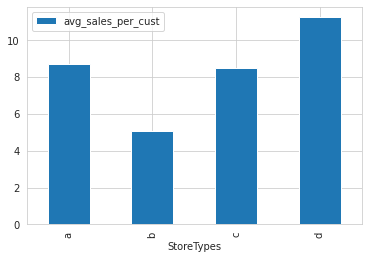

In [46]:
# barplot showing average sales percustomer for all 4 storetypes
pd.DataFrame({'StoreTypes':['a','b','c','d'],'avg_sales_per_cust':[8.71,5.06,8.5,11.25]}).set_index('StoreTypes').plot(kind='bar')

We can see Average sales per customer for StoreType d is 11.25, maximum.

In [47]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear'],
      dtype='object')

In [48]:
# creating df for month wise sales over the years
sales_2013 = df[df['Year']==2013].groupby('Month')['Sales'].sum().reset_index()
sales_2014 = df[df['Year']==2014].groupby('Month')['Sales'].sum().reset_index()
sales_2015 = df[df['Year']==2015].groupby('Month')['Sales'].sum().reset_index()

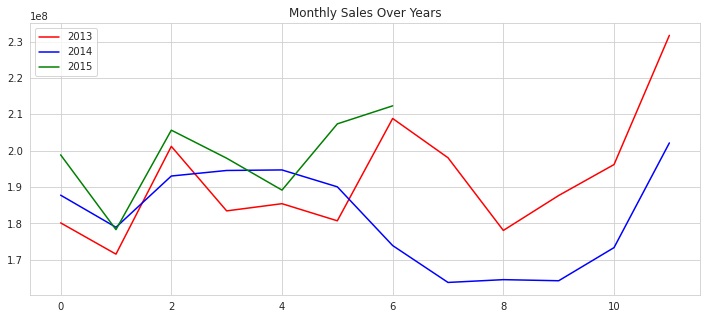

In [49]:
#plotting
plt.figure(figsize=(12,5))
plt.plot(sales_2013.loc[:,'Sales'],label='2013',color='red')
plt.plot(sales_2014.loc[:,'Sales'],label='2014',color='blue')
plt.plot(sales_2015.loc[:,'Sales'],label='2015',color='green')
plt.title('Monthly Sales Over Years')
plt.legend()

There is a significant drop in sales for around two months in 2014 data, it might be due to shops closed for refurbishment

In [86]:
sales_y2013 = df[df['Year']==2013]
sales_y2014 = df[df['Year']==2014]
sales_y2015 = df[df['Year']==2015]

This is time to check Sales distribution over the data.

Text(0.5, 1.0, 'Sales Distribution')

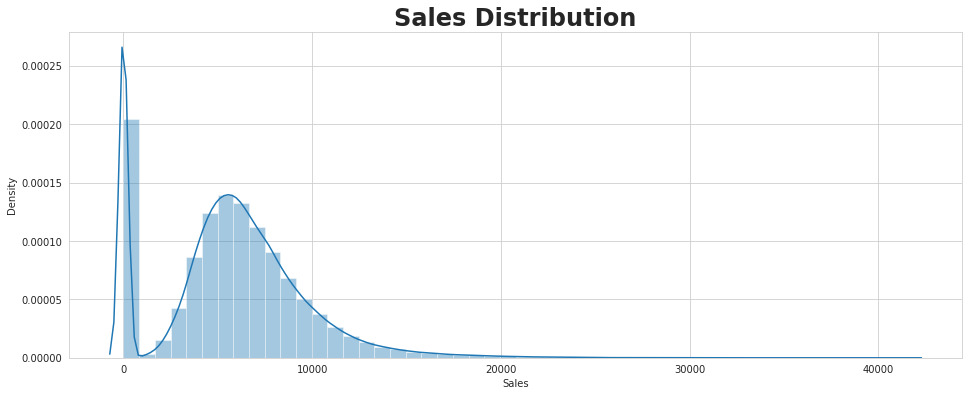

In [50]:
plt.figure(figsize=(16, 6))
sns.distplot(df['Sales']).set_title('Sales Distribution',fontdict= { 'fontsize': 24, 'fontweight':'bold'})

The drop in sales in because of those stores which were closed for refurbishment, this drop was seen in monthly sales over years in year 2014 as well.

Text(0.5, 1.0, 'Customer Distribution')

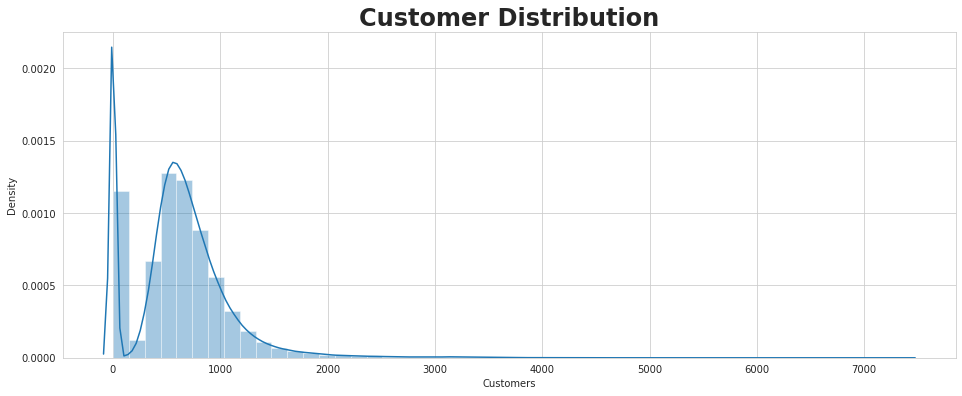

In [51]:
#distribution to see customer distribution over data
plt.figure(figsize=(16, 6))
sns.distplot(df['Customers']).set_title('Customer Distribution',fontdict= { 'fontsize': 24, 'fontweight':'bold'})

Let's check for outliers in Sales column

{'whiskers': [<matplotlib.lines.Line2D at 0x7f825fe525d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f825fdd8090>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f825fe4afd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f825fdd8b90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f825fde00d0>],
 'means': []}

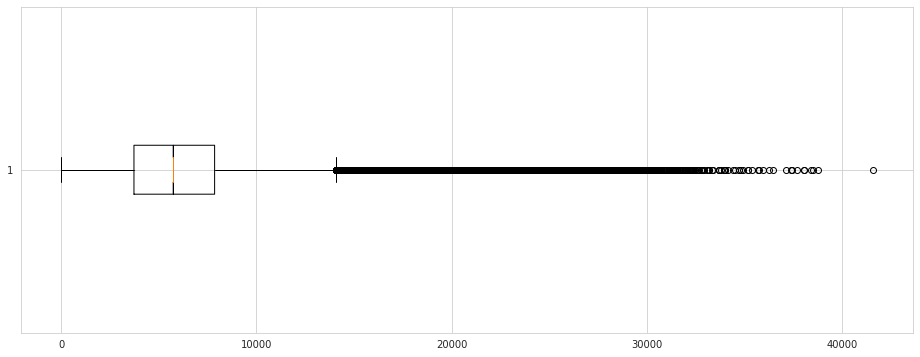

In [52]:
plt.figure(figsize=(16, 6))
plt.boxplot(df['Sales'],'Outlier in Sales Column',vert=False)

There are a lot of outliers in Sales column.

Let's check outliers in Customer data.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f825fdb97d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f825fdc0290>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f825fdb9210>],
 'medians': [<matplotlib.lines.Line2D at 0x7f825fdc0d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f825fdc92d0>],
 'means': []}

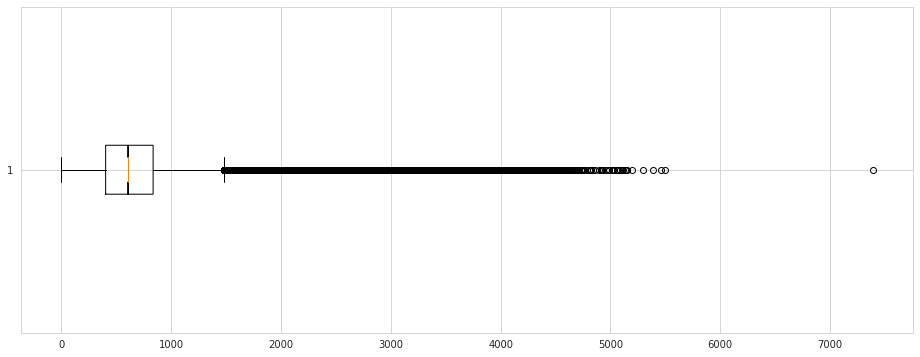

In [53]:
plt.figure(figsize=(16, 6))
plt.boxplot(df['Customers'],'Outlier in Sales Column',vert=False)

Only thing thatcould justify Outliers in Sales and Customers data is huge surge in Customer purchases during Festival seasons and promo times.

Creating a correlation matrix to see correlation between different columns, i.e, checking Multicollinearity.

But before that we need to drop some unrelated columns.


In [54]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear'],
      dtype='object')

In [55]:
df_corr = df.drop(columns=['Store', 'Date', 'Year', 'WeekOfYear', 'DayOfYear'], axis=1)

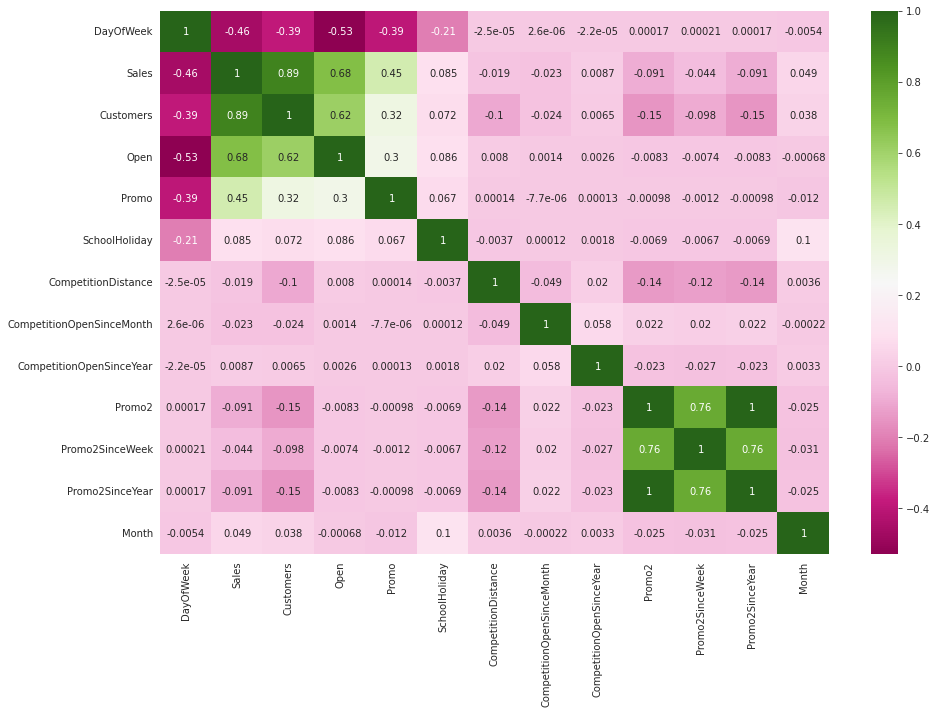

In [56]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(df_corr.corr(),cmap="PiYG", annot=True)

###Key takeaways from heatmap:


*   DayOfWeek and sales are negatively correlated, that makes sense, since overall average sales decreases as week moves from Monday to Sunday.

*   Customers and Sales has high correlation.

*   Open and Sales has good correlation.

*   Promo and sales has good correlation as well.

*   Competition Distance and Sales has negative correlation.

*   Multicollinearity can be seen in data, with Columns Promo2, Promo2SinceWeek, Promo2SinceYear being highly collinear to each other.

## Feature Engineering and Data Cleaning/Manipulation

In [57]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear'],
      dtype='object')

In [58]:
len(df[df.duplicated()])

0

Text(0.5, 1.0, 'Sales Distribution')

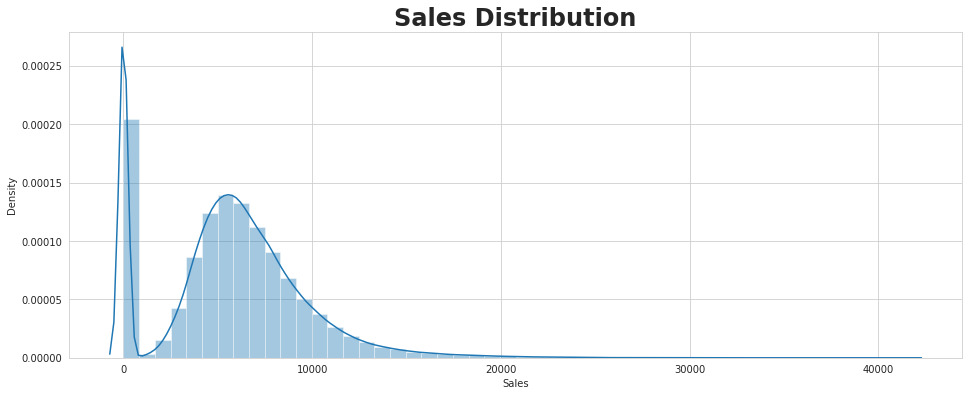

In [59]:
#distplot for dependent variable sales as we saw before also
plt.figure(figsize=(16, 6))
sns.distplot(df['Sales']).set_title('Sales Distribution',fontdict= { 'fontsize': 24, 'fontweight':'bold'})

sales are 0 for those 54 days when shops were closed for refurbishnments, and maybe some other holidays.

In [60]:
#getting number of rows where sales are zero
df[df['Sales']==0].shape

(172871, 22)

In [61]:
#getting number of days when stores were not open
df[df['Open']==0].shape

(172817, 22)

So, stores registered zero sales on days on which they were not open. We can remove these rows.

In [62]:
df1 = df[df['Open']!=0]
df1.drop(columns=['Open'], inplace=True)

Text(0.5, 1.0, 'Sales Distribution')

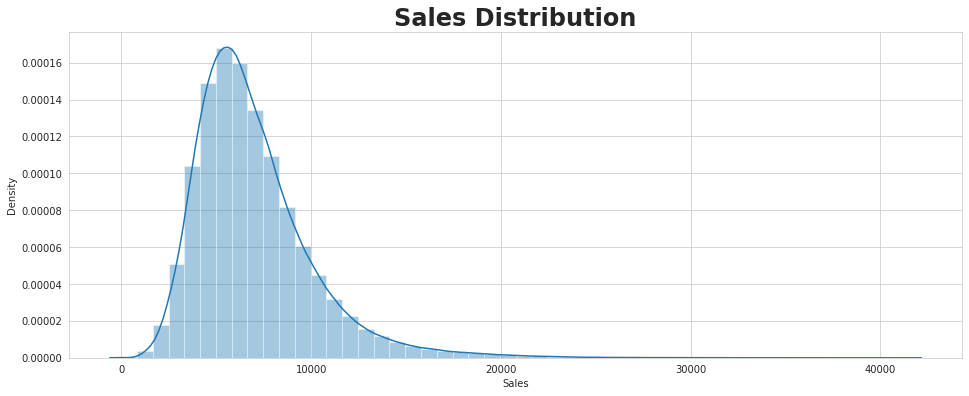

In [63]:
# let's check sales distribution again
plt.figure(figsize=(16, 6))
sns.distplot(df1['Sales']).set_title('Sales Distribution',fontdict= { 'fontsize': 24, 'fontweight':'bold'})

In [64]:
# Sales distribution is right skewed, let's try applying log transformation upon it
df1['Sales'] = np.log(df1['Sales'])

In [65]:
df1.dropna(inplace=True)

In [66]:
df1.drop(df1[df1['Sales'] == float("-inf")].index,inplace=True)

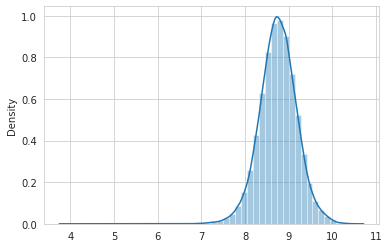

In [67]:
#distribution plot of Sales
sns.distplot(x=df1['Sales'])

Sales, is now a bit left skewed.

In [68]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear'],
      dtype='object')

In [69]:
#replacing categorical values in StateHolidays
df1.replace('StateHoliday',{'a':1,'b':1,'c':1}, inplace=True)

### Outliers

Time to detect outliers in Sales column using Z-score. It is observed that there are too many of them in Sales column, below code will find out what are those.

Total number of Outliers present in the Sales column are 1559.


[Text(0.5, 1.0, 'Outliers Distribution')]

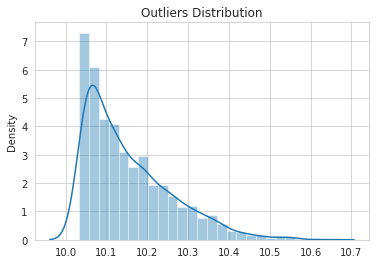

In [70]:
mean_sales = np.mean(df1['Sales']) #mean
sd_sales = np.std(df1['Sales'])   #standard deviation
#More than 3 standard deviation is an outlier
threshold = 3
#code to identify them
outliers = []
for value in df1['Sales']:
    z_score = (value-mean_sales)/sd_sales
    if z_score > threshold:
        outliers.append(value)
#total no of outliers        
print(f'Total number of Outliers present in the Sales column are {len(outliers)}.')
#plotting the outlier distribution
sns.distplot(x=outliers).set(title='Outliers Distribution')

We can see a slight deviation at datapoint 10.2, maybe after that outliers are present.

In [71]:
#percentage of sales greater than 10.2
sales_outliers = df1[df1['Sales']> 10.2]
percentage_of_outliers = (len(sales_outliers)/len(df1))*100
#print
print(f'The percentage of observations of sales greater than 28000 are {percentage_of_outliers}')

The percentage of observations of sales greater than 28000 are 0.050809036191667316


In [72]:
#exploring the reasons behind this behaviour
sales_outliers

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear
1113,1114,5,2015-07-31,10.222232,3745,1,0,1,a,c,...,9.0,2013.0,0,0.0,0.0,0,2015,7,31,212
5301,842,1,2015-07-27,10.235701,1493,1,0,0,d,c,...,11.0,2007.0,0,0.0,0.0,0,2015,7,31,208
5836,262,7,2015-07-26,10.390440,4783,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,30,207
13641,262,7,2015-07-19,10.362967,4691,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,29,200
20886,817,1,2015-07-13,10.210163,3437,1,0,0,a,a,...,3.0,2006.0,0,0.0,0.0,0,2015,7,29,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979561,262,7,2013-02-03,10.272323,4144,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2013,2,5,34
993496,817,2,2013-01-22,10.210605,7388,1,0,0,a,a,...,3.0,2006.0,0,0.0,0.0,0,2013,1,4,22
994611,817,1,2013-01-21,10.330942,3900,1,0,0,a,a,...,3.0,2006.0,0,0.0,0.0,0,2013,1,4,21
1009106,817,2,2013-01-08,10.241744,3862,1,0,0,a,a,...,3.0,2006.0,0,0.0,0.0,0,2013,1,2,8


We have already seen in our eda part that even on Sundays, StoreType b is usually open, which cintributes to their higher average sales overall, that is one the reasons why they contribute so much to outliers. Also, most of the datapoints has Promo going on.

In [73]:
#lets see which stores were open on Sunday in the outliers dataframe
#store 262
sales_outliers.loc[sales_outliers['DayOfWeek']==7]

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear
5836,262,7,2015-07-26,10.390440,4783,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,30,207
13641,262,7,2015-07-19,10.362967,4691,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,29,200
21446,262,7,2015-07-12,10.381924,4623,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,28,193
29251,262,7,2015-07-05,10.317417,4762,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,27,186
37056,262,7,2015-06-28,10.268721,4450,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,6,26,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932731,262,7,2013-03-17,10.247822,4204,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2013,3,11,76
940536,262,7,2013-03-10,10.207068,4130,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2013,3,10,69
948341,262,7,2013-03-03,10.280210,4314,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2013,3,9,62
971756,262,7,2013-02-10,10.209280,4133,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2013,2,6,41


In [74]:
#let's verify in the full dataset
df1.loc[(df1['DayOfWeek']==7) & (df1['StoreType']=='b')]

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,WeekOfYear,DayOfYear
5659,85,7,2015-07-26,9.343209,1606,0,0,0,b,a,...,10.0,2011.0,0,0.0,0.0,0,2015,7,30,207
5833,259,7,2015-07-26,9.680219,2857,0,0,0,b,b,...,9.0,2013.0,0,0.0,0.0,0,2015,7,30,207
5836,262,7,2015-07-26,10.390440,4783,0,0,0,b,a,...,5.0,2013.0,0,0.0,0.0,0,2015,7,30,207
5848,274,7,2015-07-26,8.955448,1608,0,0,0,b,b,...,9.0,2013.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",2015,7,30,207
5909,335,7,2015-07-26,8.985696,1509,0,0,0,b,a,...,9.0,2013.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,7,30,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011201,682,7,2013-01-06,8.736811,1077,0,0,0,b,a,...,9.0,2006.0,0,0.0,0.0,0,2013,1,1,6
1011252,733,7,2013-01-06,9.325988,2584,0,0,0,b,b,...,10.0,1999.0,0,0.0,0.0,0,2013,1,1,6
1011288,769,7,2013-01-06,8.852951,1764,0,0,0,b,b,...,9.0,2013.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,6
1011467,948,7,2013-01-06,8.703507,1402,0,a,0,b,b,...,9.0,2013.0,0,0.0,0.0,0,2013,1,1,6


This dataframe only varifies our earlier hypothesis that storetype b contributes most to sales outliers.

In [75]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear'],
      dtype='object')

Treating columns with high multicollinearity

In [76]:
#combining competition open since month and year into total months
df1['CompetitionOpen'] = (df1['Year'] - df1['CompetitionOpenSinceYear'])*12 + (df1['Month'] - df1['CompetitionOpenSinceMonth'])
#correcting the neg values
df1['CompetitionOpen'] = df1['CompetitionOpen'].apply(lambda x:0 if x < 0 else x)
#dropping both the columns
df1.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], axis=1,inplace=True)

In [77]:
#changing promo2 features into meaningful inputs
#combining promo2 to total months
df1['Promo2Open'] = (df1['Year'] - df1['Promo2SinceYear'])*12 + (df1['WeekOfYear'] - df1['Promo2SinceWeek'])*0.230137

#correcting the neg values
df1['Promo2Open'] = df1['Promo2Open'].apply(lambda x:0 if x < 0 else x)*df1['Promo2']

#creating a feature for promo interval and checking if promo2 was running in the sale month
def promo2running(df):
  month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
  try:
    months = df['PromoInterval'].split(',')
    if df['Month'] and month_dict[df['Month']] in months:
      return 1
    else:
      return 0
  except Exception:
    return 0

#Applying 
df1['Promo2running'] = df1.apply(promo2running,axis=1)*df1['Promo2']

#Dropping unecessary columns
df1.drop(['Promo2SinceYear','Promo2SinceWeek','PromoInterval'],axis=1,inplace=True)

In [97]:
df1_corr = df1.drop(columns=['Store', 'Date', 'Year', 'WeekOfYear', 'DayOfYear'], axis=1)

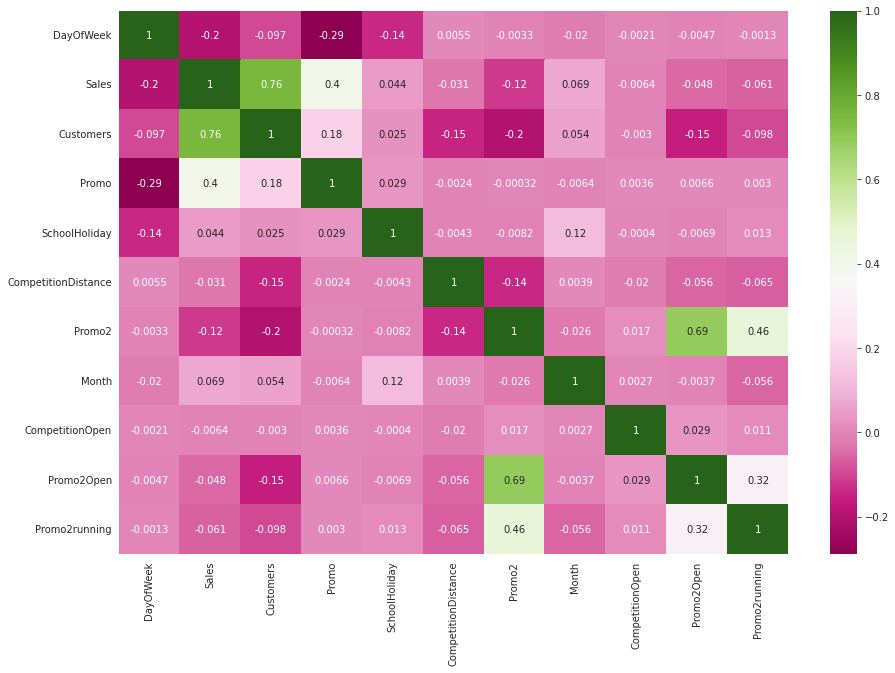

In [98]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(df1_corr.corr(),cmap="PiYG", annot=True)

In [99]:
df1.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,WeekOfYear,DayOfYear,CompetitionOpen,Promo2Open,Promo2running
0,1,5,2015-07-31,8.568456,555,1,0,1,c,a,1270.0,0,2015,7,31,212,82.0,0.000000,0
1,2,5,2015-07-31,8.710125,625,1,0,1,a,a,570.0,1,2015,7,31,212,92.0,64.142466,1


In [78]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Year', 'Month', 'WeekOfYear',
       'DayOfYear', 'CompetitionOpen', 'Promo2Open', 'Promo2running'],
      dtype='object')

**Outlier Treatment**

* Treating outliers in Sales and Customers will impact our predictions.

* Becuase, Sales have outliers due to StoreType b being open even on Sundays.

* Also, a lot of days which are contributing to outliers have Promo going on, which makes justifies their higher sales.

* Treating outliers will only result in reduced prediction accuracy and while a model might fit well on train data, it will have high variance on Test data.

In [84]:
# just for safety
df2 = df1.copy()

### **Model Selection:**

**Test-Train-Split**

In [102]:
#slicing the most recent six weeks and creating train and test set
#train
start_train = "2013-01-01"
end_train = "2015-06-14"
df_train = df2.loc[start_train:end_train]

#test
start_test = "2015-06-15"
end_test = "2015-07-31"
df_test = df2.loc[start_test:end_test]

In [ ]:
hi = pd.to_csv()